In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import timm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Hyperparameters
BATCH_SIZE = 128
NUM_BITS = 4
BETA = 2.0
LAMBDA = 0.01  # Regularization weight

def compute_fisher_information(model, dataloader, device):
    model.eval()
    fisher_information = {}
    for name, param in model.named_parameters():
        if "weight" in name:
            fisher_information[name] = torch.zeros_like(param, device=device)

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        model.zero_grad()
        outputs = model(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()

        for name, param in model.named_parameters():
            if "weight" in name and param.grad is not None:
                fisher_information[name] += (param.grad ** 2)
        break

    return fisher_information

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Load Pretrained ResNet18 from timm
import resnet18

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18.resnet18(pretrained=False, device=device)
model.to(device)

state_dict = torch.load('/content/resnet18.pt', map_location=torch.device('cpu'))
model.load_state_dict(state_dict, strict=False)
model.eval()
model.to(device)

# Compute Fisher Information
fisher_information = compute_fisher_information(model, train_loader, device)

100%|██████████| 170M/170M [00:02<00:00, 60.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


<ipython-input-2-1e0636034fab>:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/resnet18.pt', map_location=torch.device('cpu'))


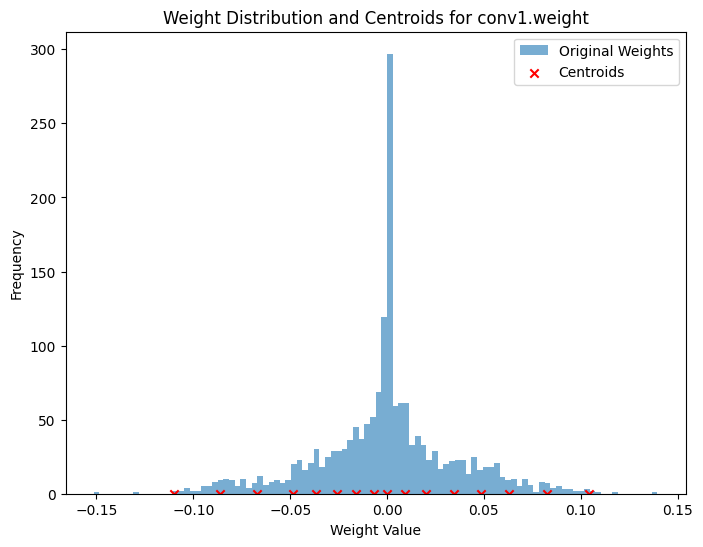

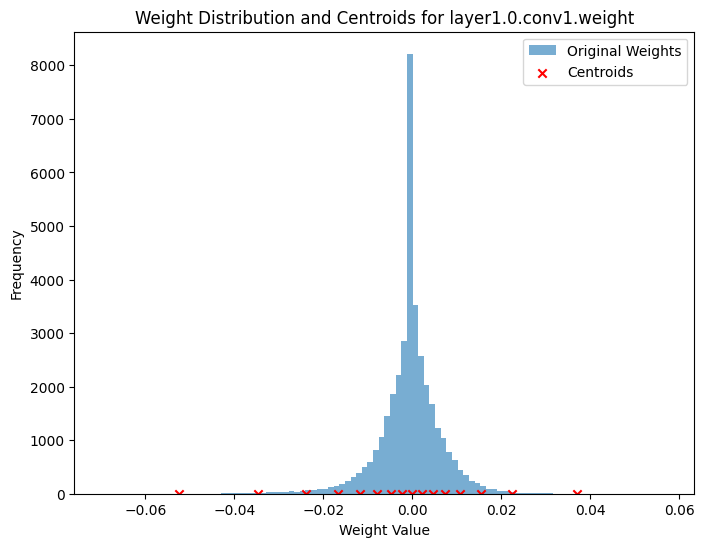

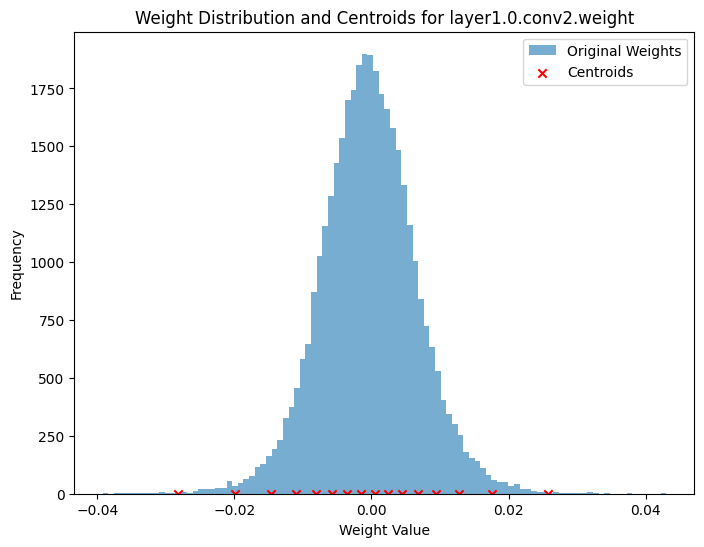

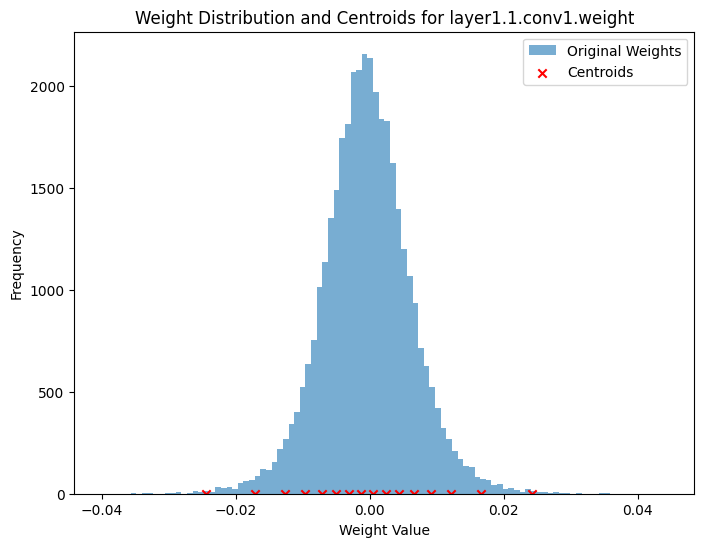

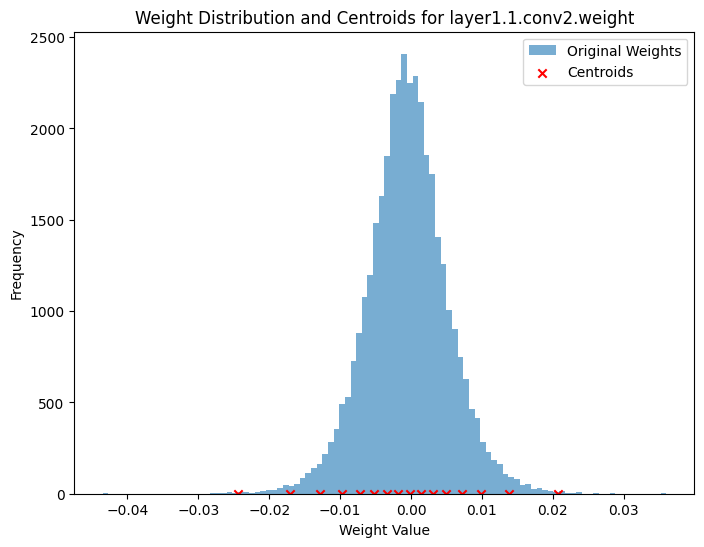

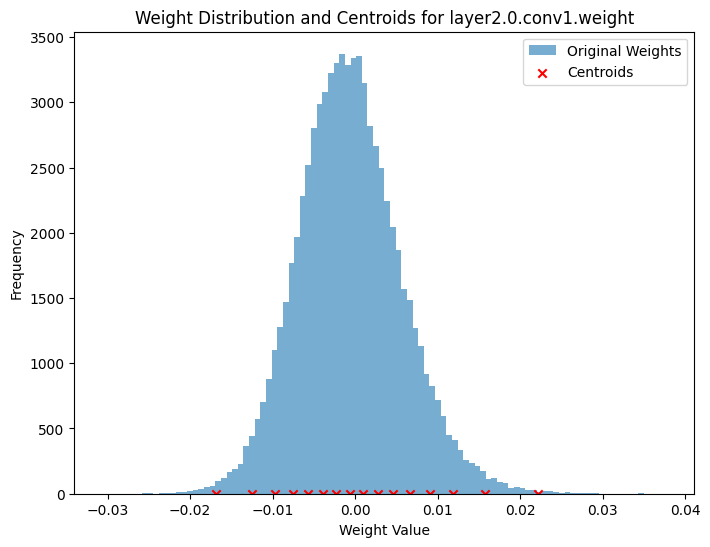

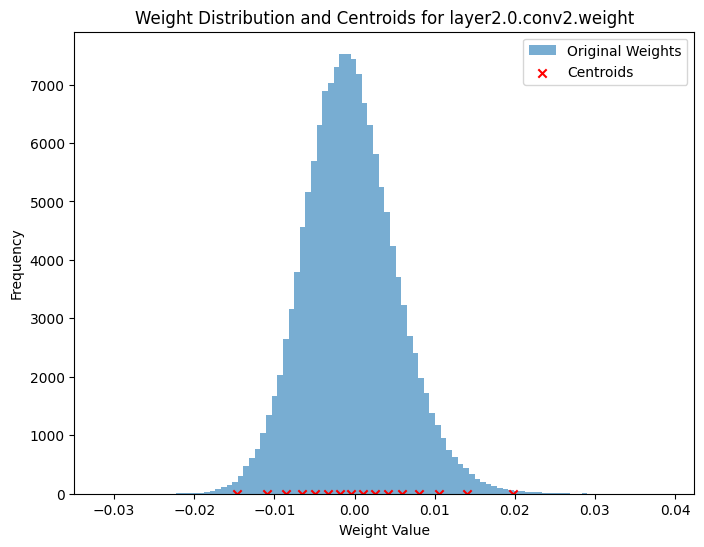

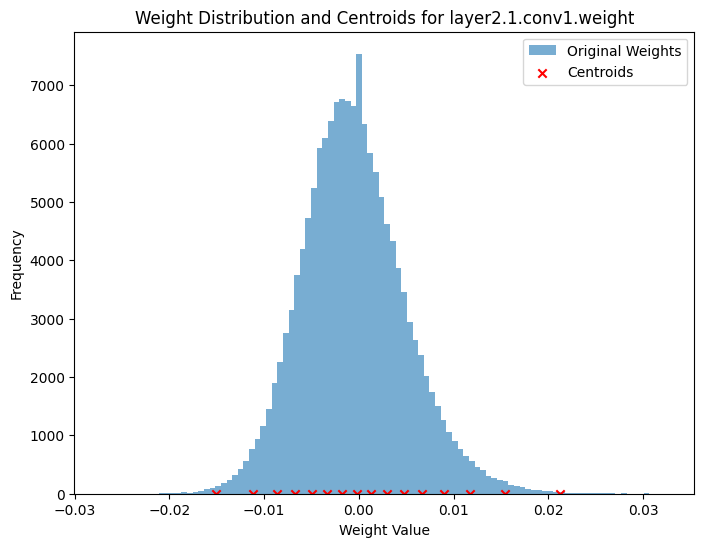

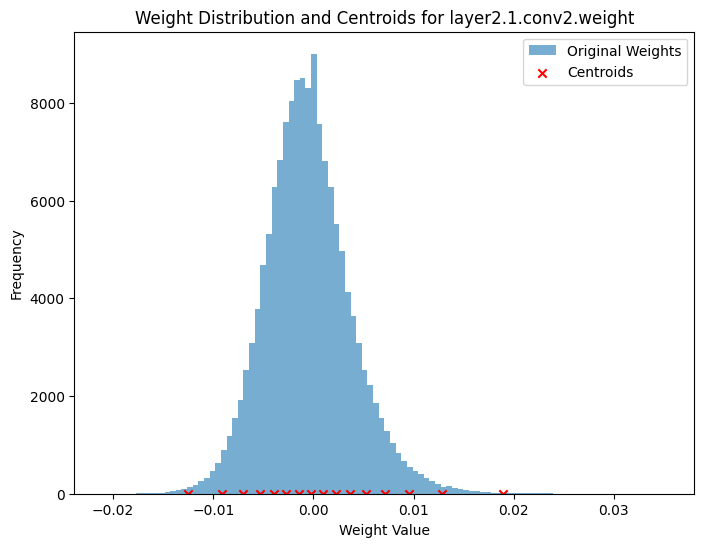

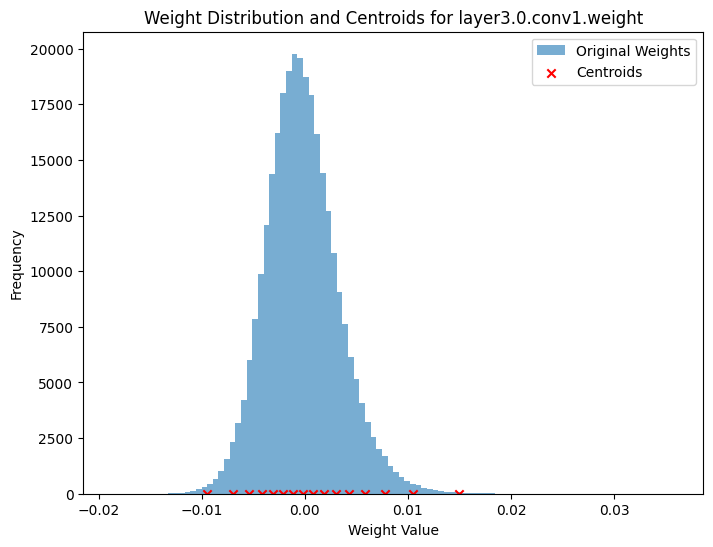

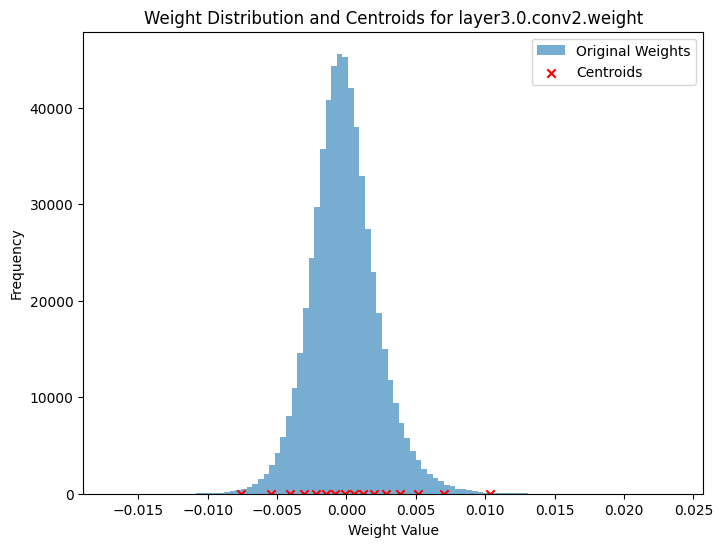

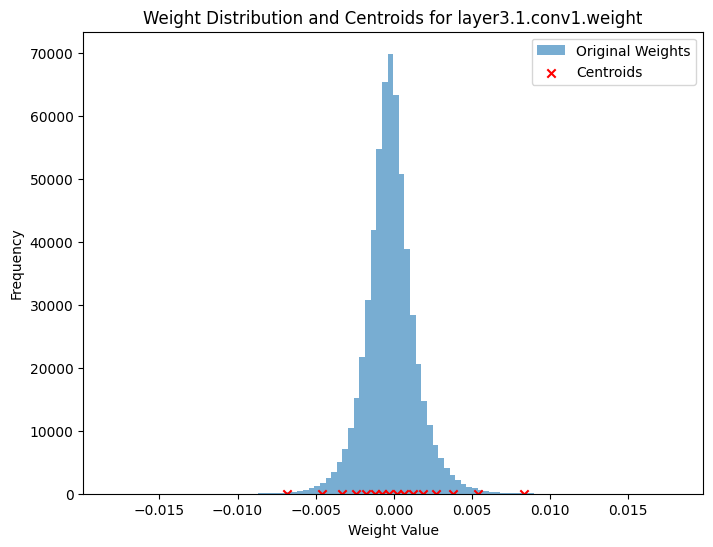

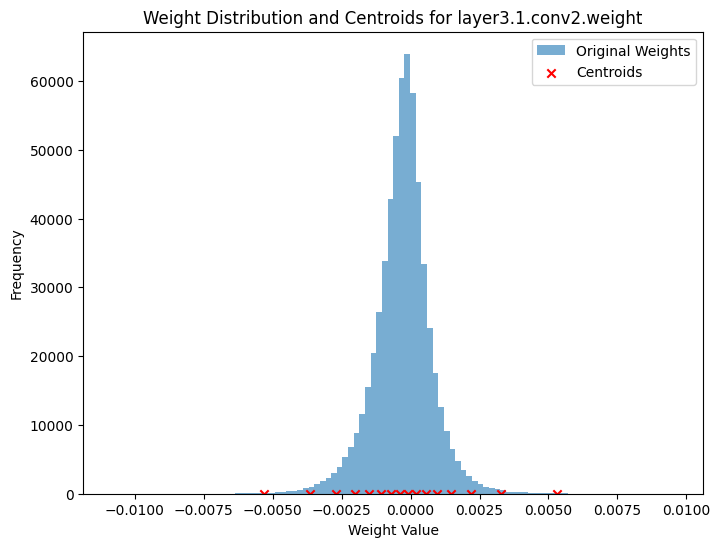

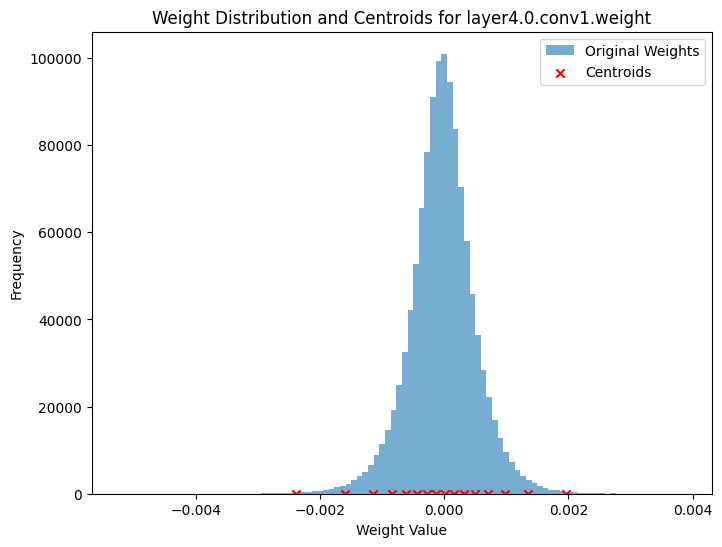

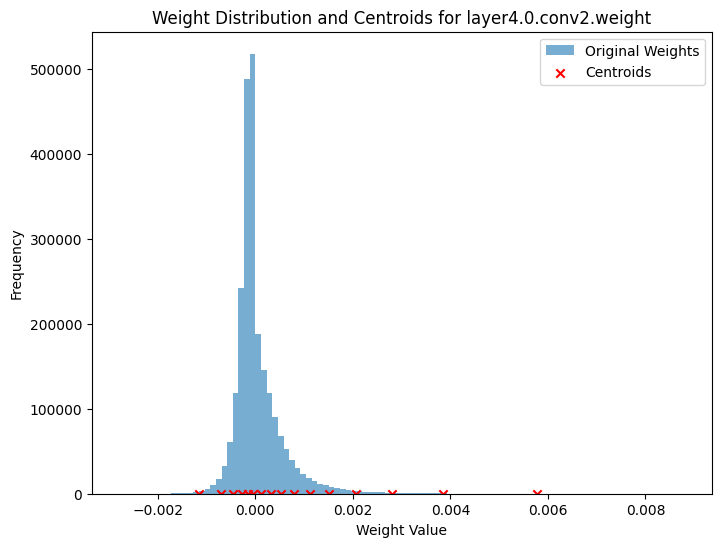

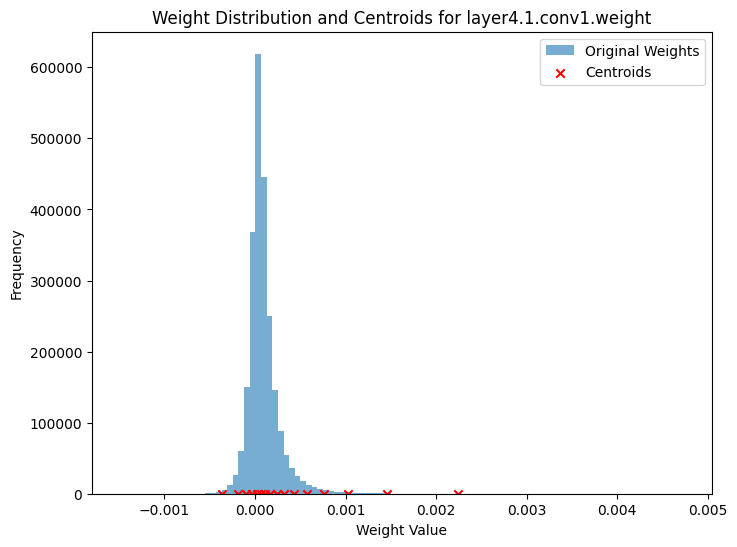

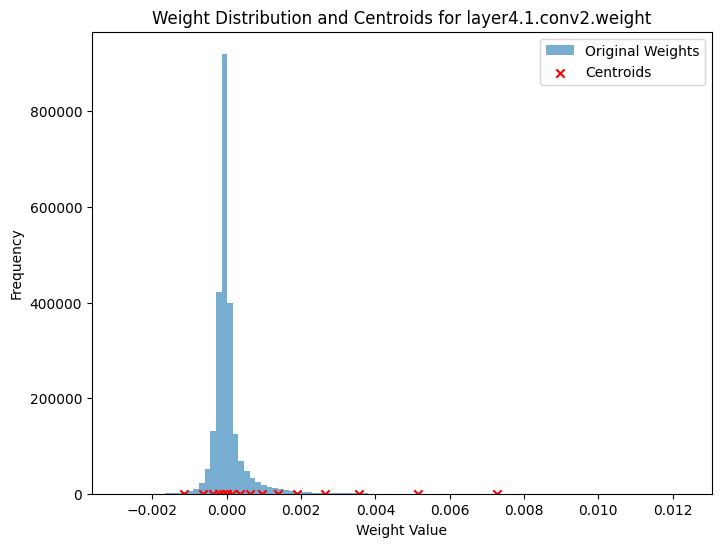

In [ ]:
def uniform_quantization(tensor, num_bits=NUM_BITS, name=None):
    min_val, max_val = tensor.min(), tensor.max()

    # Compute Fisher Information sensitivity mask
    if name and name in fisher_information:
        fisher_info = fisher_information[name]
        sensitivity_mask = fisher_info > torch.quantile(fisher_info, 0.45)
        sensitive_weights = tensor[sensitivity_mask]
    else:
        sensitivity_mask = torch.abs(tensor) > torch.quantile(torch.abs(tensor), 0.45)
        sensitive_weights = tensor[sensitivity_mask]

    offset = sensitive_weights.mean() if sensitive_weights.numel() > 0 else tensor.mean()
    tensor_shifted = tensor - offset

    # Apply sensitivity-aware clustering (k-means)
    tensor_flat = tensor.view(-1, 1).cpu().numpy()
    kmeans = KMeans(n_clusters=2 ** num_bits, n_init=10).fit(tensor_flat)
    clustered_tensor = torch.tensor(kmeans.cluster_centers_[kmeans.labels_], device=tensor.device).view(tensor.shape)

    # Apply sensitivity-aware clustering (k-means)
    #tensor_flat = sensitive_weights.view(-1, 1).cpu().numpy()
    #kmeans_sens = KMeans(n_clusters=2 ** num_bits, n_init=10).fit(tensor_flat)
    #clustered_tensor = torch.tensor(kmeans.cluster_centers_[kmeans.labels_], device=tensor.device).view(tensor.shape)
    fisher_flat = fisher_info.view(-1)  # Flatten
    top_indices = torch.argsort(fisher_flat, descending=True)[:20]  # Get top 20 indices
    top_sensitive_weights = tensor_flat[top_indices].tolist()  # Store top values

    # Plot centroids and weight distribution
    plt.figure(figsize=(8, 6))
    plt.hist(tensor.cpu().numpy().flatten(), bins=100, alpha=0.6, label="Original Weights")
    plt.scatter(kmeans.cluster_centers_, np.zeros_like(kmeans.cluster_centers_), color='red', label="Centroids", marker='x')
    #plt.scatter(top_sensitive_weights, np.zeros_like(top_sensitive_weights), color='green', label="Centroids", marker='x')
    plt.title(f"Weight Distribution and Centroids for {name}")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
# Apply Uniform Quantization to Conv Layers Only
for name, param in model.named_parameters():
    if "conv" in name and "weight" in name:
        uniform_quantization(param.data, name=name)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import timm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Hyperparameters
BATCH_SIZE = 128
NUM_BITS = 3
BETA = 2.0
LAMBDA = 0.01  # Regularization weight
A_BASE = 0.05  # Default power function base value
GAMMA = 0.5  # Controls adaptation strength

def compute_fisher_information(model, dataloader, device):
    model.eval()
    fisher_information = {}
    for name, param in model.named_parameters():
        if "weight" in name:
            fisher_information[name] = torch.zeros_like(param, device=device)

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        model.zero_grad()
        outputs = model(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()

        for name, param in model.named_parameters():
            if "weight" in name and param.grad is not None:
                fisher_information[name] += (param.grad ** 2)
        break

    return fisher_information

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Load Pretrained ResNet18 from timm
import resnet18

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18.resnet18(pretrained=False, device=device)
model.to(device)

state_dict = torch.load('/content/resnet18.pt', map_location=torch.device('cpu'))
model.load_state_dict(state_dict, strict=False)
model.eval()
model.to(device)

# Compute Fisher Information
fisher_information = compute_fisher_information(model, train_loader, device)

# Compute Sensitivity Weighted Matrix
def compute_sensitivity_weighted_matrix(tensor, fisher_info):
    sensitivity_weights = fisher_info / (torch.max(fisher_info) + 1e-8)  # Normalize sensitivity values
    weighted_matrix = tensor * sensitivity_weights  # Element-wise multiplication
    return weighted_matrix, sensitivity_weights

# Compute per-layer adaptive power function a
def compute_adaptive_a(fisher_info):
    normalized_fisher = fisher_info.mean() / (fisher_info.max() + 1e-8)  # Normalize to [0,1]
    return 0.55
    #return A_BASE + GAMMA * (1 - normalized_fisher)

# Modify uniform quantization to use sensitivity weighted matrix mean
def uniform_quantization(tensor, num_bits=NUM_BITS, name=None):
    min_val, max_val = tensor.min(), tensor.max()

    # Compute Fisher Information sensitivity mask
    if name and name in fisher_information:
        fisher_info = fisher_information[name]
        weighted_matrix ,sensitivity_weights = compute_sensitivity_weighted_matrix(tensor, fisher_info)
        #offset = (weighted_matrix.sum() / sensitivity_weights.sum()).item()
        offset = tensor.mean().item()
        # Adapt power function based on sensitivity
        adaptive_a = compute_adaptive_a(fisher_info)
    else:
        offset = tensor.mean().item()
        adaptive_a = torch.full_like(tensor, 0.55)

    print(offset)
    print(adaptive_a)
    # Default power value if no sensitivity info
    # Apply sensitivity-aware clustering (k-means)
    #tensor_flat = tensor_shifted.view(-1, 1).cpu().numpy()
    #kmeans = KMeans(n_clusters=2 ** num_bits, n_init=10).fit(tensor_flat)
    #clustered_tensor = torch.tensor(kmeans.cluster_centers_[kmeans.labels_], device=tensor.device).view(tensor.shape)
    tensor_shifted = tensor - offset

    # Apply power function scaling (x^0.55)
    tensor_sign = torch.sign(tensor_shifted)
    tensor_scaled = tensor_shifted.abs() ** adaptive_a * tensor_sign  # Preserve sign

    scale = (tensor_scaled.max() - tensor_scaled.min()) / (2 ** num_bits - 1)
    quantized_tensor = torch.round((tensor_scaled - tensor_scaled.min()) / scale) * scale + tensor_scaled.min()

    # Descale back to original range and apply offset correction
    quantized_tensor = ((quantized_tensor.abs() ** (1/adaptive_a)) * torch.sign(quantized_tensor)) + offset

    return quantized_tensor

# Apply Uniform Quantization to Conv Layers Only
for name, param in model.named_parameters():
    if "conv" in name and "weight" in name:
        param.data = uniform_quantization(param.data, name=name)

# Reload state dict to ensure updated weights are used
#model.load_state_dict(model.state_dict())

# Evaluate Model after Quantization
def evaluate(model, test_loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy after Quantization: {100 * correct / total:.2f}%")

evaluate(model, test_loader)


Files already downloaded and verified
Files already downloaded and verified


<ipython-input-23-152dedca30df>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/resnet18.pt', map_location=torch.device('cpu'))


-0.0005907987360842526
0.55
-0.0005312355933710933
0.55
-0.00038865581154823303
0.55
-0.0004040412895847112
0.55
-0.0004977902863174677
0.55
-0.0006040212465450168
0.55
-0.0004886134411208332
0.55
-0.0005380698712542653
0.55
-0.0005172945093363523
0.55
-0.0002259942120872438
0.55
-0.00016324553871527314
0.55
-0.00020669298828579485
0.55
-0.0002927689638454467
0.55
-3.338038004585542e-05
0.55
4.645423905458301e-05
0.55
9.021561709232628e-05
0.55
2.5723662474774756e-05
0.55
Test Accuracy after Quantization: 83.07%


In [ ]:
# Reduce model size and dataset for memory efficiency
class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Use a smaller dataset
subset_trainset = torch.utils.data.Subset(trainset, range(0, 5000))  # Reduce training set to 5000 images
subset_testset = torch.utils.data.Subset(testset, range(0, 1000))  # Reduce test set to 1000 images

trainloader = torch.utils.data.DataLoader(subset_trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(subset_testset, batch_size=64, shuffle=False, num_workers=2)

# Train and evaluate new small model
small_model = SmallCNN().to(device)
optimizer = optim.Adam(small_model.parameters(), lr=0.001)

print("Training smaller baseline model...")
train_model(small_model, trainloader, criterion, optimizer, epochs=3)
baseline_acc = evaluate_model(small_model, testloader)
print(f"Smaller Baseline Model Accuracy: {baseline_acc:.4f}")
# Function to perform hybrid Tucker decomposition with quantization
def quantize_tensor(tensor, bits=4):
    """Applies k-bit uniform quantization to a tensor."""
    qmin = -2**(bits-1)
    qmax = 2**(bits-1) - 1
    scale = (tensor.max() - tensor.min()) / (qmax - qmin)
    tensor_q = torch.round(tensor / scale).clamp(qmin, qmax)
    return tensor_q * scale

def get_adaptive_tucker_rank(tensor, energy_threshold=0.95):
    """Selects Tucker decomposition rank dynamically based on energy preservation."""
    ranks = []
    for mode in range(len(tensor.shape)):
        unfold = tl.unfold(tensor, mode)
        U, S, V = torch.svd(unfold)
        cumulative_energy = torch.cumsum(S, dim=0) / torch.sum(S)
        rank = torch.sum(cumulative_energy < energy_threshold).item() + 1
        ranks.append(rank)
    return tuple(ranks)

def hybrid_tucker_quantization(weight_tensor, quant_bits=4, energy_threshold=0.95):
    """Applies Tucker decomposition with adaptive rank selection and quantization."""
    rank = get_adaptive_tucker_rank(weight_tensor, energy_threshold)
    print(rank)
    #core, factors = tucker(weight_tensor, ranks=rank)
    #core_q = quantize_tensor(core, bits=quant_bits)
    #reconstructed = tl.tucker_to_tensor((core_q, factors))
    return weight_tensor
# Apply Tucker compression to a single layer (conv1 only) for testing
def compress_single_layer(model, layer_name):
    """Applies Tucker + Quantization only to a specific layer."""
    for name, param in model.named_parameters():
        if layer_name in name and 'weight' in name:
            print(f"Compressing {name}...")
            param.data = hybrid_tucker_quantization(param.data, quant_bits=4, energy_threshold=0.95)
    return model

compressed_model = compress_single_layer(small_model, "conv1")

# Fine-tune after compression
print("Fine-tuning compressed small model...")
train_model(compressed_model, trainloader, criterion, optimizer, epochs=3)

# Evaluate compressed model
compressed_acc = evaluate_model(compressed_model, testloader)
print(f"Compressed Model Accuracy: {compressed_acc:.4f}")

# Return accuracy results
baseline_acc, compressed_acc


Training smaller baseline model...
Epoch 1, Loss: 1.9802278144450127
Epoch 2, Loss: 1.646470074412189
Epoch 3, Loss: 1.507406676871867
Smaller Baseline Model Accuracy: 0.4720
Compressing conv1.weight...
(14, 3, 3, 3)
Fine-tuning compressed small model...
Epoch 1, Loss: 1.4321407864365396
Epoch 2, Loss: 1.3375384324713597
Epoch 3, Loss: 1.2604732241811631
Compressed Model Accuracy: 0.4680


(0.472, 0.468)

In [ ]:
!pip install tensorly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import tensorly as tl
from tensorly.decomposition import tucker
import numpy as np

tl.set_backend('pytorch')  # Use PyTorch as backend for TensorLy

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define CNN model for CIFAR-10
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Train function
def train_model(model, trainloader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

# Evaluate function
def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Initialize and train model
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Training baseline model...")
train_model(model, trainloader, criterion, optimizer, epochs=5)

# Baseline Accuracy
baseline_acc = evaluate_model(model, testloader)
print(f"Baseline Accuracy: {baseline_acc:.4f}")

# Function to perform hybrid Tucker decomposition with quantization
def quantize_tensor(tensor, bits=4):
    """Applies k-bit uniform quantization to a tensor."""
    qmin = -2**(bits-1)
    qmax = 2**(bits-1) - 1
    scale = (tensor.max() - tensor.min()) / (qmax - qmin)
    tensor_q = torch.round(tensor / scale).clamp(qmin, qmax)
    return tensor_q * scale

def get_adaptive_tucker_rank(tensor, energy_threshold=0.95):
    """Selects Tucker decomposition rank dynamically based on energy preservation."""
    ranks = []
    for mode in range(len(tensor.shape)):
        unfold = tl.unfold(tensor, mode)
        U, S, V = torch.svd(unfold)
        cumulative_energy = torch.cumsum(S, dim=0) / torch.sum(S)
        rank = torch.sum(cumulative_energy < energy_threshold).item() + 1
        ranks.append(rank)
    return tuple(ranks)

def hybrid_tucker_quantization(weight_tensor, quant_bits=4, energy_threshold=0.95):
    """Applies Tucker decomposition with adaptive rank selection and quantization."""
    rank = get_adaptive_tucker_rank(weight_tensor, energy_threshold)
    core, factors = tucker(weight_tensor, ranks=rank)
    core_q = quantize_tensor(core, bits=quant_bits)
    reconstructed = tl.tucker_to_tensor((core_q, factors))
    return reconstructed

# Apply compression to convolutional layers
def compress_model(model):
    for name, param in model.named_parameters():
        if 'conv' in name and 'weight' in name:
            print(f"Compressing {name}...")
            param.data = hybrid_tucker_quantization(param.data, quant_bits=4, energy_threshold=0.95)
    return model

# Compress and fine-tune the model
compressed_model = compress_model(model)
print("Fine-tuning compressed model...")
train_model(compressed_model, trainloader, criterion, optimizer, epochs=3)

# Evaluate compressed model accuracy
compressed_acc = evaluate_model(compressed_model, testloader)
print(f"Compressed Model Accuracy: {compressed_acc:.4f}")

# Return accuracy results
baseline_acc, compressed_acc


Files already downloaded and verified
Files already downloaded and verified
Training baseline model...
Epoch 1, Loss: 1.344856800020808
Epoch 2, Loss: 0.9728826912467742
Epoch 3, Loss: 0.8091560569413178


KeyboardInterrupt: 

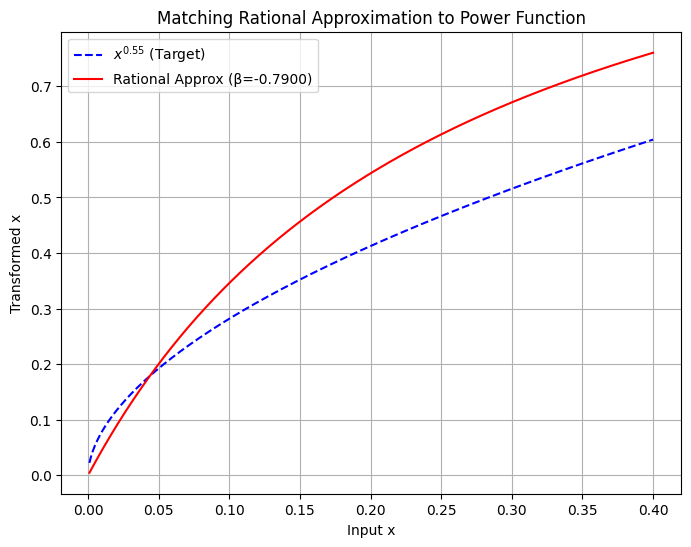

-0.79

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the original power function
def power_function(x, alpha=0.55):
    return np.sign(x) * np.abs(x) ** alpha

# Define the rational approximation function
def rational_approximation(x, beta):
    return x / (1 + beta * (1 - x))

# Generate a range of input values
x_values = np.linspace(0.001, 0.4, 1000)  # Avoid zero to prevent division issues

# Compute outputs for different beta values
alpha_target = 0.55
best_beta = None
min_error = float('inf')

beta_values = np.linspace(-1, 0, 1000)  # Search range for beta

for beta in beta_values:
    rational_output = rational_approximation(x_values, beta)
    power_output = power_function(x_values, alpha_target)

    # Compute mean squared error between rational and power approximation
    error = np.mean((rational_output - power_output) ** 2)

    if error < min_error:
        min_error = error
        best_beta = beta
best_beta = -0.79
# Plot the best match
plt.figure(figsize=(8, 6))
plt.plot(x_values, power_function(x_values, alpha_target), label=r'$x^{0.55}$ (Target)', linestyle='dashed', color='blue')
plt.plot(x_values, rational_approximation(x_values, best_beta), label=f'Rational Approx (β={best_beta:.4f})', color='red')
plt.xlabel("Input x")
plt.ylabel("Transformed x")
plt.legend()
plt.title("Matching Rational Approximation to Power Function")
plt.grid()
plt.show()

best_beta


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import timm
import numpy as np

# Hyperparameters
BATCH_SIZE = 128
NUM_BITS = 3
BETA = 2.0
LAMBDA = 0.01  # Regularization weight

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load Pretrained ResNet18 from timm
import resnet18

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18.resnet18(pretrained=False, device=device)
model.to(device)

state_dict = torch.load('/content/resnet18.pt', map_location=torch.device('cpu'))
model.load_state_dict(state_dict, strict=False)
model.eval()
model.to(device)

# Rational Approximation-Based Uniform Quantization
def rational_approximation_quantization(tensor, num_bits=NUM_BITS, beta=-0.79):
    min_val, max_val = tensor.min(), tensor.max()

    # Compute offset to center weights
    offset = tensor.mean()
    tensor_shifted = tensor - offset

    # Apply rational approximation scaling
    tensor_scaled = tensor_shifted / (1 + beta * (1 - tensor_shifted))

    scale = (tensor_scaled.max() - tensor_scaled.min()) / (2 ** num_bits - 1)
    quantized_tensor = torch.round((tensor_scaled - tensor_scaled.min()) / scale) * scale + tensor_scaled.min()

    # Descale back to original range and apply offset correction
    quantized_tensor = (quantized_tensor * (1 + beta * (1 - quantized_tensor))) + offset

    return quantized_tensor

# Apply Uniform Quantization to Conv Layers Only
for name, param in model.named_parameters():
    if "conv" in name and "weight" in name:
        param.data = rational_approximation_quantization(param.data)

# Evaluate Model after Quantization
def evaluate(model, test_loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy after Quantization: {100 * correct / total:.2f}%")

evaluate(model, test_loader)


Files already downloaded and verified
Files already downloaded and verified


<ipython-input-27-c906fb4fc969>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/resnet18.pt', map_location=torch.device('cpu'))


Test Accuracy after Quantization: 9.96%
